In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Neural Networks
This is a visual representation of a neural network over a single sample.  
<div>
    <img src="nn_img.png" width="150"/>
</div>


In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
#offset by 1 to account for our special character '.'
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(stoi)
itos = {i:s for s,i in stoi.items()}

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [3]:
# creating the bigram training set
# xs <- input
# ys <- labels (for use in the loss function and training)
xs, ys = [], []

for w in words[:]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print('number of samples (bigrams): ', len(xs))
print(xs.shape)

number of samples (bigrams):  228146
torch.Size([228146])


##### One Hot Encoding
One hot encoding encodes class indices (class labels) into vectors whose corresponding column bit is flipped.
eg: 'a' will be a vector whose first entry is 1 and the rest 0.
This is so the input can be fed into a NN.

torch.Size([228146, 27])
torch.Size([228146])


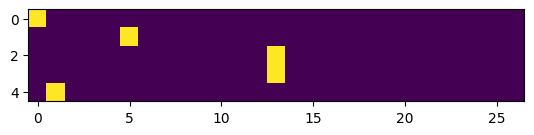

In [4]:
xenc = F.one_hot(xs, num_classes=27).float()
print(xenc.shape)
print(xs.shape)
plt.imshow(xenc[:5])

In [5]:
# Randomly initialize the weights of 27 neurons. each neuron receives 27 inputs (xs), so they get 27 weights each.
# the output of each neurons represent the log probability of a character appearing next
    # the output of each neuron through is the entries of the mat mul (xenc @ W)
# basically, W is a linear map T: float[27] -> float[27]
W = torch.randn([27, 27], dtype=torch.float32, requires_grad=True)

---
### Example

In [11]:
# Example: for xs[0], the log-count of the next character is given by the vector
logit = (xenc @ W)[0]
counts = logit.exp()
probs = counts / counts.sum()
print(logit.data)
print(counts.data)
print(probs.data)
print(probs.sum().item())
# Since, this example is untrained, do not expect anything close to the actual value
print(f"from model: {probs[ys[0]]}, actual: 1")

tensor([-1.6987,  1.4856,  0.3359,  0.2004,  0.1515,  0.4962, -0.2049, -0.4369,
        -0.0732, -0.2897,  0.3125,  0.9367,  0.2069,  0.9226, -0.6114, -0.3826,
        -0.2972, -0.5829,  0.3995,  0.7398,  0.2564, -0.4321, -0.3426, -0.4539,
        -0.6205, -0.0384, -0.0383])
tensor([0.1829, 4.4178, 1.3992, 1.2219, 1.1636, 1.6425, 0.8147, 0.6460, 0.9294,
        0.7485, 1.3669, 2.5516, 1.2298, 2.5159, 0.5426, 0.6821, 0.7429, 0.5583,
        1.4911, 2.0956, 1.2923, 0.6492, 0.7099, 0.6351, 0.5377, 0.9623, 0.9624])
tensor([0.0056, 0.1351, 0.0428, 0.0374, 0.0356, 0.0502, 0.0249, 0.0198, 0.0284,
        0.0229, 0.0418, 0.0780, 0.0376, 0.0770, 0.0166, 0.0209, 0.0227, 0.0171,
        0.0456, 0.0641, 0.0395, 0.0199, 0.0217, 0.0194, 0.0164, 0.0294, 0.0294])
1.0000001192092896
from model: 0.050242677330970764, actual: 1


---

##### Forward Pass (Forward Propogation)
the calculation and storage of intermediate variables (including outputs) for a neural network in order from the input layer to the output layer.

We will interpret the outputs of the neurons as log counts.
When a log count is exponentiated, we get a positive number we can interpret as the count.
See the graph for $e^x$ for how this works.

##### Softmax
A softmax activation function is a common layer in a neural net that takes in a real vector and outputs another real vector. The output's entries are all positive and sum to 1. That is, the outputs are probabilities.
This is very common in NNs because the output of neural networks often contain negative values and are not normalized. 

Note: matrix multiplication, exponentiation, summation, etc. are all differentiable operations and functions. This is important because we need to take the partial derivatives w.r.t to each weight during backpropogation

##### Backward Pass (Back Propogation)
Given the loss, we calculate the gradients with respect to each weight. Then, we perform gradient descent by adjusting each weight with the corresponding gradient.

In [7]:
# GRADIENT DESCENT
for k in range(5):
    # FORWARD PASS
    logits = (xenc @ W) # log-counts
    counts = logits.exp() # counts, (larger count = more likely) 
    probs = counts / counts.sum(1, keepdims=True) # probability for the next character
    # Note: the last 2 lines above are together called a 'softmax activation function'
    
    # Normalized negative log likelihood
        # we take the log likelihood of each predicted label, then we sum and normalize with .mean() to get a real-valued loss'
        # Recall the graph of -ln(). Minimizing -ln() is akin to maximizing the probabilities of the predicted labels 
        # which is exactly what we want to do, as the predicted labels should have higher probability than not. 
    loss = -probs[torch.arange(len(xs)), ys].log().mean()    
    # BACKWARD PASS
    W.grad = None # set to zero the gradient
    # pytorch keeps track of all operations on the tensor, 
    # so we can just call backward() to get the gradients with respect to each weight
    loss.backward()

    # UPDATES
    eta = 50
    # -eta to perform gradient descent as W.grad points in the direction of greatest increase
    W.data += -eta * W.grad
    print(loss.item())
print(W.grad.shape)


3.8435580730438232
3.4316062927246094
3.1786553859710693
3.0190486907958984
2.916682243347168
torch.Size([27, 27])


---
##### Log Likelihood 
The **likelihood** of an outcome is the product of the probabilities of each token eg: $a*b*c$.
Since log is a monotonic function, we can use log likelihood in place of likelihood and still get the desired behavior.
Moreover, the property that $\log(a*b*c)=\log(a)+\log(b)+\log(c)$ is convenient in vectorized calculations of log likelihood.

Note: for performing gradient descent, we will be using the negative log likelihood function.
The $\log$ function has the property that it is 0 at `prob=1` and approaches $-\infty$ as `prob` approaches 0.
Clearly the $log$ function has no local minima in $[0, 1]$, but the negative log likelihood does.

If we want to perform gradient ascent, we would use a gain function.

In [8]:
print(probs[torch.arange(len(xs)), ys][:5].tolist())
print(probs[torch.arange(len(xs)), ys][:5].log().tolist())
print(-probs[torch.arange(len(xs)), ys][:5].log().mean().item())

[0.053098954260349274, 0.017353732138872147, 0.030328070744872093, 0.20883412659168243, 0.1867654025554657]
[-2.935598134994507, -4.053947448730469, -3.4956815242767334, -1.5662150382995605, -1.6779019832611084]
2.7458691596984863


---
##### Regularization
Regularization is the process of smoothing the distribution of weights.
This is done by adding a *regularization loss* term to the loss function 
whose purpose it is to penalizes nonzero weights.

This is beneficial for reducing complexity. The more 0 weights we have, the less weights we have to process. 

The regularization below is an example of **L2 regularization**, with the L2 term $\lambda \mathbf{w}^2$


In [9]:
reg_loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01*(W**2).mean()
reg_loss

tensor(2.9250, grad_fn=<AddBackward0>)

In [10]:
# SAMPLING FROM MODEL
for i in range(5):
    out = []
    ix = 0;
    
    while True:
        # begin with '.'
        _xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        _logits = _xenc @ W 
        _counts = _logits.exp()
        P = _counts / _counts.sum(1, keepdims=True)
        
        ix = torch.multinomial(P, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

jf.
c.
mai.
ayoa.
e.
